# Data 620: Final Project
### Aaron Grzasko
### 12/18/2018

## Introduction

*The Sopranos* is a critically acclaimed crime TV series that originally aired on HBO from 1999 to 2007.
The series follows Tony Soprano, a New Jersey-based mafia boss who struggles with depression.  Throughout the drama's six seasons, Tony strives to maintain a normal, suburban family lifes while also leading a criminal enterprise and engaging in frequent salacious and violent behavior.

The show features a sprawling storyline and a large cast of characters--characteristics that are well-suited for social network analysis.

Furthermore, many of the characters in *The Sopranos* exhibit conflicting and shifting loyalties throughout the series' timeline.  Mafia members within the Soprano criminal organiztion are often at odds with other.  Some characters serve as informants to police as a last ploy to avoid lengthy prison sentences.  There is even an episode in the series where Tony's mother appears request a "hit" on her son.  Using sentiment analysis, we hope to capture some of the shifting dyamics between cast members.     


## Data Overview

Ideally, we would have liked to perform an analysis using all 86 episodes from six seasons of *The Sopranos*.  
Dialogue for all episodes is freely available online--see [springfieldspringfield.co.uk](https://www.springfieldspringfield.co.uk/episode_scripts.php?tv-show=the-sopranos).  Unfortunately, the springfield website does not specify which characters are speaking each line of dialogue.  To use this data set, we would need to infer the speaker from contextual clues or assign speaker names manually while watching full episodes. 

Due to the limitations of the available online data, we decided to purchase the ebook, *The Sopranos: Selected Scripts From Three Seasons* by David Chase.  The character dialogue from the book can be easily scraped using two popular python libaries: *epub* and *BeautifulSoup*.  The downside to this data source is scripts are provided for only five Sopranos episodes.  On the other hand, the book clearly attributes each line of dialogue to a specific character, which is imperative for performing
meaningful analysis.  
  
Here is an overview of the five episodes from the book:  
* "The Sopranos" - season one, episode one.
 - Tony visits a therapist after fainting.
 - Uncle Junior plans a hit inside Artie Bucco's restauarant.
 - Tony orders Silvio to set fire to the restaurant to prevent the hit.
* "College" - season one, episode five.  
 - Tony takes his daughter Meadow on a road trip to visit prospective colleges.
 - While on the road trip, Tony hunts down a former mafia member turned FBI informant.
* "The Happy Wanderer" - season two, episode six.
 - Tony team overseas a high-stakes poker game.
 - Tony's college friend David, a compulsive gambler, joins the game.  
 - Unable to cover his losses, David gives his son's SUV to Tony as parital payment.  
 
* "The Knight in White Satin Armor" - season two, episode twelve. 
 - Tony's mistress, Irina, attempts to commit suicide after Tony tries to break up with her.
 - Big Pussy wears a wire and provides information to the FBI.
 - Janice, Tony's sister, kills her fiance--mafia captain Richie--after a brief alteraction.
* "Pine Barrens" - season three, episode eleven.
  - Tony's associates, Paulie and Christopher, have an altercation with Russian mobster, Valery.
  - They transport Valery to the Pine Barrens to kill and bury him.
  - Valery ends up escaping.  Paulie and Christopher end up lost in the woods. 

## Read in Data

Before we perform any analysis, we will import all relevant python libaries:

In [257]:
# import relevant libraries
import epub
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import math
import seaborn as sns
import warnings
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# declare default behavior within notebook
warnings.filterwarnings('ignore')
%matplotlib inline

Now let's read in the data.

In [3]:
# establish connection to ebook
book  =  epub.open_epub('Sopranos.epub')

# specify episodes to read-in
ep1 = book.read_item(book.get_item_by_href('Sopranos_chap_1.html')) 
ep2 = book.read_item(book.get_item_by_href('Sopranos_chap_2.html'))
ep3 = book.read_item(book.get_item_by_href('Sopranos_chap_3.html'))
ep4 = book.read_item(book.get_item_by_href('Sopranos_chap_4.html'))
ep5 = book.read_item(book.get_item_by_href('Sopranos_chap_5.html'))

## Data Scrubbing

The data are not yet in a format amenable to perfoming network or sentiment analysis.  
The episode dialogue are in the form of raw HTML.  Using regex and BeautifulSoup packages, we wrangle the data into cleaner form and store in a pandas DataFrame.  

Below are multiple helper functions used to scrub the raw HTML dialogue.

In [4]:
def scrub_script(episode):
    """Initial scrubbing script:
            Reads scene number/description, character, and relevant dialogue
    """
    # extract relevant text relating to scene number, character, and corresponding dialogue.
    script = BeautifulSoup(episode, 'lxml')
    script = script.find_all("p", ["p1","dt1","np2"])
    script = [s.text for s in script]
    
    # remove extraneous text on lines referencing the character who is speaking
    script = [s.replace('(V.O.)','') for s in script]
    script = [s.replace("(CONT’D)","") for s in script]
    script = [s.replace("\n","") for s in script]
    script = [s.replace("(0.S.)","") for s in script]
    script = [s.replace("(O.S.)","") for s in script]
    script = [s.replace("(O.S)","") for s in script]
            
    return(script)   


def find_scene(script):
    """
    Determine scene number:
        For each line of text, determine the applicable scene number 
    """
    
    # assign scene number to each line in text
    scene = list(map(lambda x: "".join(re.findall('^\\d+|CUT TO:',x)),script))
    for i in range(len(scene)):
        scene[i] = scene[i] if scene[i] != '' else scene[i-1]
    
    # regex isn't perfect.  Manually fix mistakenly assigned scene numbers. 
    scene = [s.replace("327","7") for s in scene]
    
    return scene


def find_dialogue(script):
    """
    Extract dialogue from text, if applicable
    """
    dialogue = []
    
    # pull text dialogue if line meets specified criteria
    for ln in script:
        if re.search("[a-z]+", ln) and not re.search('^\\d+',ln):
            dialogue.append(ln.strip())
    
    # otherwise assign "Not Dialogue" to line
        else:
            dialogue.append("Not Dialogue")
    return(dialogue)


def find_characters(script):
    """
    Pull character name from line, if applicable
    """
    characters = []
    # pull text specifying character, if applicable
    for ln in script:
            try:
                if re.search("^[A-Z\\. ]{2,}[A-Z\\. ]+",ln) and not re.search("[a-z]|CUT TO|!",ln):
                    name = "".join(re.findall("^[A-Z\\. ]{2,}[A-Z\\. ]+",ln))
                    characters.append(name.strip())
                else:
                    characters.append(characters[-1])
    # otherwise, assign "Not Character"
            except:
                    characters.append("Not Character")
    
    # fix character names that are either misspelled or referenced using multiple names
    characters = [s.replace("BIG PUSSY","PUSSY") for s in characters]
    characters = [s.replace("PAULIE WALNUTS","PAULIE") for s in characters]
    characters = [s.replace("MELEI","MELFI") for s in characters]
    characters = [s.replace("DAVTD","DAVID") for s in characters]
    
    return(characters)


def line_type(char_list, dialogue_list):
    """
    Assign each line of file to one of three types:
            "character", "dialogue", or "scene"
    """
    line_type = []
    for i in range(len(char_list)):
        if dialogue_list[i] == "Not Dialogue":
            if char_list[i] == "Not Character":
                line_type.append('scene')
            else:
                line_type.append("character")
        else:
            line_type.append("dialogue")
    return(line_type)
            

def episode_df(episode, ep_no):
    """
    Using other helper functions, consolidate
    raw HTML data to pandas dataframe
    """
   
    script = scrub_script(episode)
    scene = find_scene(script)
    char = find_characters(script)
    dial = find_dialogue(script)
    lt = line_type(char,dial)
    ep = [ep_no] * len(char)
    
    d = {'episode': ep,'line_type': lt, 'scene':scene, 'character': char,  'dialogue':dial}
    df = pd.concat([pd.Series(v, name=k) for k, v in d.items()], axis=1)
    df = df[(df.line_type == 'dialogue') & (df.character != "Not Character")]
    return(df)

Using the helper functions defined above, we save the episode script data to a pandas DataFrame. 

In [5]:
# save data for each episode in separate dataframe
df1 = episode_df(ep1, 1)
df2 = episode_df(ep2, 2)
df3 = episode_df(ep3, 3)
df4 = episode_df(ep4, 4)
df5 = episode_df(ep5, 5)

# concatenate all data together
frames = [df1, df2, df3, df4, df5]
df_all = pd.concat(frames)

## View Data

Here are the first ten lines from our newly created DataFrame:

In [6]:
# view first 10 lines from dataframe
df_all.head(10)

,episode,line_type,scene,character,dialogue
2,1,dialogue,1,MELFI,Mr. Soprano?
5,1,dialogue,2,MELFI,Have a seat.
7,1,dialogue,2,MELFI,"My understanding from your family physician, D..."
9,1,dialogue,2,TONY,They said it was a panic attack — because all ...
11,1,dialogue,2,MELFI,You don’t agree you had a panic attack?
13,1,dialogue,2,MELFI,How are you feeling now?
15,1,dialogue,2,TONY,Now? Fine. I’m back at work.
17,1,dialogue,2,MELFI,What line of work are you in?
19,1,dialogue,2,TONY,Waste management consultant.
21,1,dialogue,2,MELFI,Any thoughts at all on why you blacked out?


Below is a list of the unique characters with speaking parts in the five Sopranos episodes.  There are almost 100 characters in total.

In [7]:
characters_all = list(set(df_all.character))

print("There are {} unique characters.".format(len(characters_all)))
print("\nList of characters:")
print(sorted(characters_all))

There are 93 unique characters.

List of characters:
['ADRIANA', 'ALBERT', 'ANNOUNCER VOICE', 'ANTHONY JR.', 'ARTHUR', 'ARTIE', 'ATTENDANT', 'BACALA', 'BARBARA', 'BARTENDER', 'BEPPY', 'BOTH PARENTS', 'BOWDOIN STUDENT', 'CAITLIN', 'CARMELA', 'CHARMAINE', 'CHRISTOPHER', 'COMPUTER VOICE', 'COP', 'CUBITOSO', 'DAUGHTER', 'DAVID', 'DEALER', 'DEAN', 'DICK BARONE', 'DIRECTOR', 'DR. FREID', 'ERIC', 'FATHER PHIL', 'FISH MAN', 'FRANK SINATRA JR.', 'FURIO', 'GABRIELLA', 'GLORIA', 'HERMAN', 'HILLEL', 'HOOKER', 'HOSTESS', 'HUGH', 'HUNTER', 'ILANA', 'IRINA', 'JACKIE JR.', 'JANICE', 'JOHNNY SACK', 'JUNIOR', 'KIDS', 'KOLAR', 'LE DOYENNNE', 'LILLIANA', 'LIPARI', 'LIVIA', 'LUCINDA', 'MAHAFFEY', 'MAHENDRA', 'MALE VOICE', 'MAN', 'MARY', 'MATT', 'MEADOW', 'MELFI', 'MELVOIN', 'MRS. GAETANO', 'MRS. SCATINO', 'NILS', 'NURSE', 'OWNER', 'PARVATI', 'PAULIE', 'PETERS', 'PRIEST', 'PUSSY', 'REP', 'RICHIE', 'RICK', 'RITA', 'ROSALIE', 'SEAN', 'SILVIO', 'SLAVA', 'STUDENT WORKER', 'SUNSHINE', 'SVETLANA', 'TONY', 'TONY A

## Network Analysis

We define a pair of characters to have interacted (i.e. are connected) if both individuals have speaking parts within the same episode scene.  Characters that speak in multiple scenes together will have higher edge weights.  
  
Before we build our network graph, we build a couple helper functions to determine the number of interactions between pairs of characters.

In [9]:
def sort_tuple(x):
    """
    Helper function to sort tuple ordering in alphabetical order.
        For instance, '(Tony, Carmela)' and '(Carmela, Tony)' will both
        sort to '(Carmela, Tony)'.
    
    """
    mylist = []
    for e in x:
        mylist.append(tuple(sorted([e[0],e[1]])))
    return(set(mylist))
                   
def interactions(df):
    """
    Determine number of interactions between pairs
        of characters.
    """
    df_unique = df.groupby(['episode','scene','character']).size().reset_index().rename(columns={0:'count'})
    #print(df_unique)
    interactions = dict()
    
    for ep in df_unique.episode.unique():
        for scn in df_unique.scene.unique():
            temp_df = df_unique[(df_unique.scene == scn) & (df_unique.episode == ep)]
            temp_inter = sort_tuple(list(itertools.combinations(set(temp_df.character),2)))
            for pair in temp_inter:
                if pair in interactions:
                    interactions[pair] += 1
                else:
                    interactions[pair] = 1
    return(interactions)
                  


**Full Sopranos Graph**

Now we are ready to produce the graph.

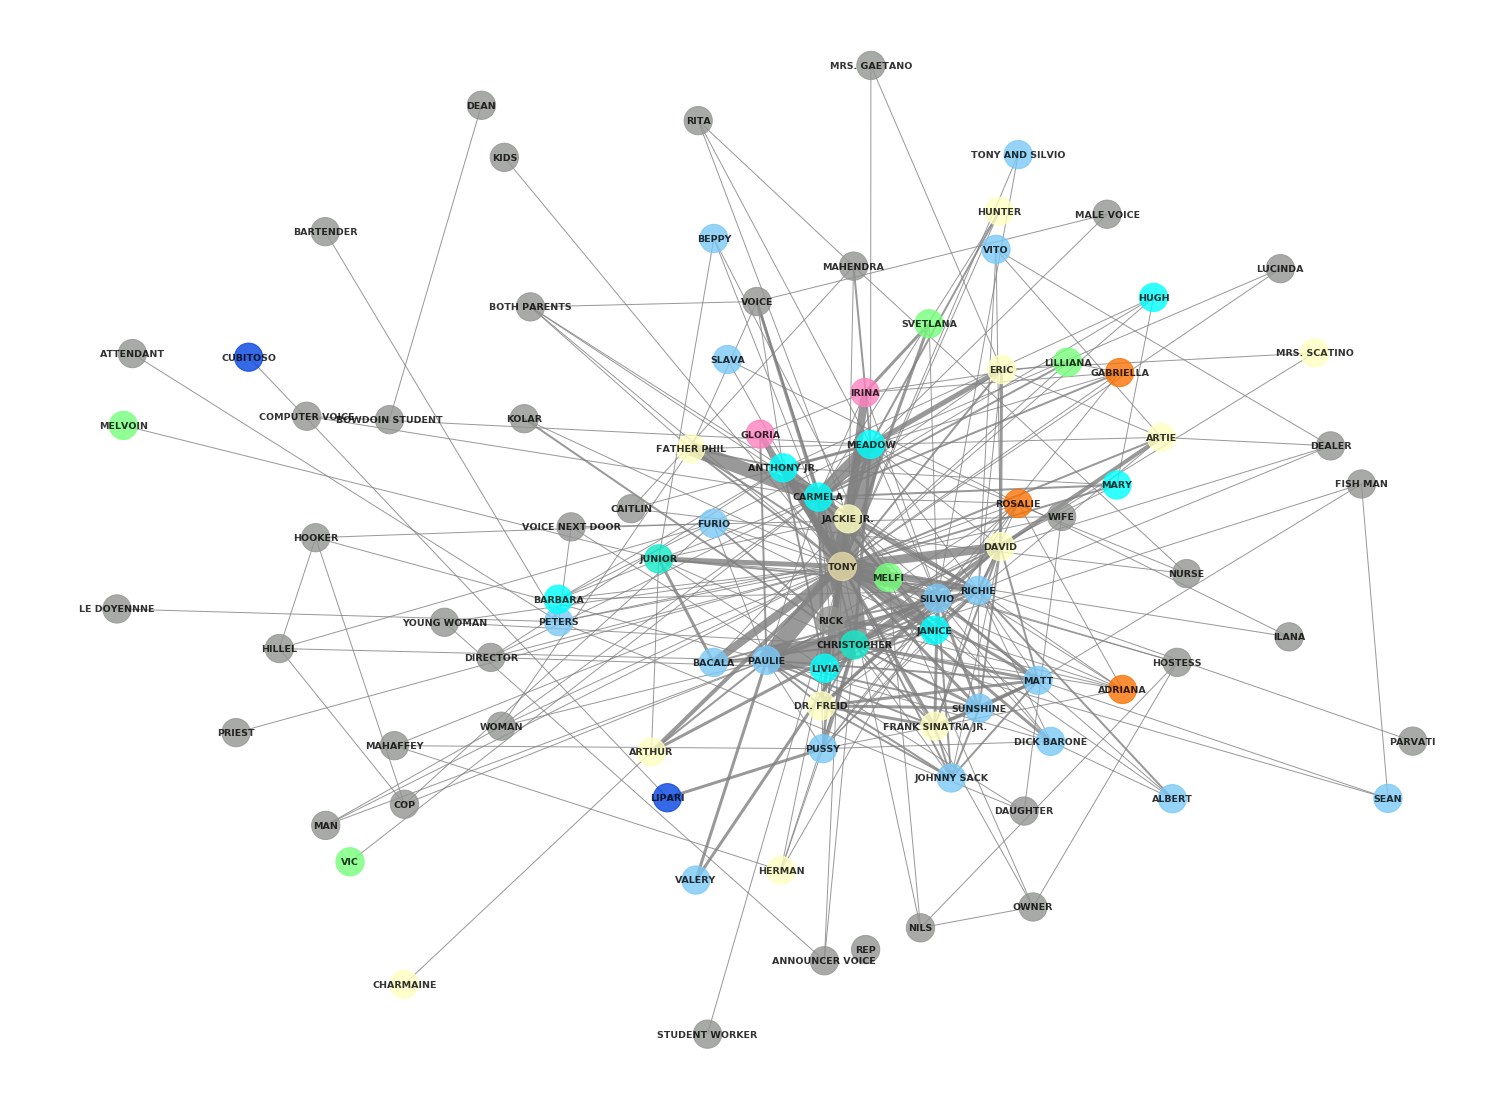

In [69]:
#instantiate network graph
G=nx.Graph()

# define interactions between characters
interactions_all = interactions(df_all)

# create graph edges
edge_tuples = list()
for k,v in interactions_all.items():
    edge_tuples.append((k[0],k[1],v))

# add nodes to graph
G.add_nodes_from(characters_all)

# assign character type
char_typ = {'ADRIANA':'Mafia Significant Other', 'ALBERT':'Mafia', 'ANNOUNCER VOICE':'Other', 'ANTHONY JR.':'Immediate Family',
 'ARTHUR':'Family Friend', 'ARTIE':'Family Friend', 'ATTENDANT':'Other', 'BACALA':'Mafia', 'BARBARA':'Immediate Family',
 'BARTENDER':'Other', 'BEPPY':'Mafia', 'BOTH PARENTS':'Other', 'BOWDOIN STUDENT':'Other', 'CAITLIN':'Other',
 'CARMELA':'Immediate Family', 'CHARMAINE':'Family Friend', 'CHRISTOPHER':'Mafia/Extended Family',
 'COMPUTER VOICE':'Other', 'COP':'Other', 'CUBITOSO':'FBI', 'DAUGHTER':'Other', 'DAVID':'Family Friend',
 'DEALER':'Other', 'DEAN':'Other', 'DICK BARONE':'Mafia', 'DIRECTOR':'Other', 'DR. FREID':'Family Friend',
 'ERIC':'Family Friend', 'FATHER PHIL':'Family Friend', 'FISH MAN':'Other', 'FRANK SINATRA JR.':'Family Friend',
 'FURIO':'Mafia', 'GABRIELLA':'Mafia Significant Other', 'GLORIA':'Mistress', 'HERMAN':'Family Friend',
 'HILLEL':'Other', 'HOOKER':'Other', 'HOSTESS':'Other', 'HUGH':'Immediate Family', 'HUNTER':'Family Friend',
 'ILANA':'Other', 'IRINA':'Mistress', 'JACKIE JR.':'Family Friend', 'JANICE':'Immediate Family',
 'JOHNNY SACK':'Mafia', 'JUNIOR':'Mafia/Extended Family', 'KIDS':'Other', 'KOLAR':'Other',
 'LE DOYENNNE':'Other', 'LILLIANA':'Service Provider', 'LIPARI':'FBI', 'LIVIA':'Immediate Family',
 'LUCINDA':'Other', 'MAHAFFEY':'Other', 'MAHENDRA':'Other', 'MALE VOICE':'Other', 'MAN':'Other',
 'MARY':'Immediate Family', 'MATT':'Mafia', 'MEADOW':'Immediate Family', 'MELFI':'Service Provider',
 'MELVOIN':'Service Provider', 'MRS. GAETANO':'Other', 'MRS. SCATINO':'Family Friend',
 'NILS':'Other', 'NURSE':'Other', 'OWNER':'Other', 'PARVATI':'Other', 'PAULIE':'Mafia',
 'PETERS':'Mafia', 'PRIEST':'Other', 'PUSSY':'Mafia', 'REP':'Other', 'RICHIE':'Mafia',
 'RICK':'Other', 'RITA':'Other', 'ROSALIE':'Mafia Significant Other', 'SEAN':'Mafia',
 'SILVIO':'Mafia', 'SLAVA':'Mafia', 'STUDENT WORKER':'Other', 'SUNSHINE':'Mafia',
 'SVETLANA':'Service Provider', 'TONY':'Tony', 'TONY AND SILVIO':'Mafia', 'VALERY':'Mafia',
 'VIC':'Service Provider', 'VITO':'Mafia', 'VOICE':'Other', 'VOICE NEXT DOOR':'Other',
 'WIFE':'Other', 'WOMAN':'Other', 'YOUNG WOMAN':'Other'}

nx.set_node_attributes(G, char_typ, name='char_typ')

# add weighted edges
G.add_weighted_edges_from(edge_tuples)

# store edge weights in list
edges = G.edges()
weights = [G[u][v]['weight'] for u,v in edges]


# assign colors
def assign_col(G):
    """
    Assign colors to nodes based on character type
    """

    node_col = []
    for g in G.nodes(data=True):
        #print(g[1]['char_typ'])
        if "Tony" in g[1]['char_typ']:
            node_col.append('xkcd:beige')
        elif "Mafia Significant Other" in g[1]['char_typ']:
            node_col.append('xkcd:orange')
        elif "Mafia/Extended Family" in g[1]['char_typ']:
            node_col.append('xkcd:aqua')
        elif "Mafia" in g[1]['char_typ']:
            node_col.append('xkcd:lightblue')
        elif "Immediate Family" in g[1]['char_typ']:
            node_col.append('xkcd:cyan')
        elif "FBI" in g[1]['char_typ']:
            node_col.append('xkcd:blue')
        elif "Mistress" in g[1]['char_typ']:
            node_col.append('xkcd:pink')
        elif "Service Provider" in g[1]['char_typ']:
            node_col.append('xkcd:lightgreen')
        elif "Family Friend" in g[1]['char_typ']:
            node_col.append('xkcd:cream')
        else:
            node_col.append('xkcd:gray')
    
    return(node_col)

node_col = assign_col(G)

# plot graph
plt.figure(figsize=(20,15)) 
nx.draw(G, with_labels=True, font_size = 9.5, node_size = 800,\
        font_weight = 'bold', alpha = 0.8, node_color=node_col, edge_color='gray', 
        pos=nx.spring_layout(G,k=0.40, iterations=20), width = weights)

We colored the nodes based on the character attributes that were assigned manually--and in some cases, subjectively.  

Below is a mapping of node colors:
* Beige - Tony
* Light Blue - Mafia
* Cyan - Immediate Family
* Aqua - Mafia/Extended Family
* Orange - Mafia Significant Other
* FBI - Blue
* Mistress - Pink
* Service Provider - Light Green
* Family Friend - Cream
* Other - Grey


Here are our initial observations from the graph:  
* Tony appears in the center of the graph, and has the highest number of interactions.  This makes sense, as Tony is the lead character in the show.
* Tony's primary interactions involve his immediate family, higher level mafia personnel (i.e. captains), and close family friends.
* Tony also interacts frequently with his psychiatrist, Dr. Melfi.
* The FBI do appear to have a significant influence in the social network.
* The graph is not 100% connected.  There are a few stragglers:
    - A character, REP, does not interact with the other characters 
    - Two others, DEAN and BOWDOIN Student, interact with each other, but not with the larger, connected subgraph


**Basic Graph Metrics and Charts**

Here are some high-level statisticis for our network:

In [70]:
# size of network
print("size of network: {}".format(len(G)))

# graph diameter
subgraph = list(nx.connected_component_subgraphs(G))[1]
print("\nlargest subgraph diameter: {}".format(nx.diameter(subgraph)))

# maximum degree
print("\nmaximum weighted degree: {}".format(max(G.degree(weight='weight'), key=lambda x: x[1])))

# minimum degree
print("minimum weighted degree: {}".format(min(G.degree(weight='weight'), key=lambda x: x[1])))

# top 10 nodes in terms of degree
print("\nTop 10 Weighted Degrees:")

# top 10 
print(sorted([(x,y) for x,y in G.degree(weight='weight')], key=lambda z: z[1], reverse=True)[0:10])

print("\nBottom 10 Weighted Degrees:")
print(sorted([(x,y) for x,y in G.degree(weight='weight')], key=lambda z: z[1])[0:10])



size of network: 93

largest subgraph diameter: 5

maximum weighted degree: ('TONY', 262)
minimum weighted degree: ('REP', 0)

Top 10 Weighted Degrees:
[('TONY', 262), ('CHRISTOPHER', 108), ('CARMELA', 101), ('PAULIE', 79), ('MEADOW', 70), ('RICHIE', 46), ('SILVIO', 41), ('DAVID', 40), ('ANTHONY JR.', 31), ('MELFI', 30)]

Bottom 10 Weighted Degrees:
[('REP', 0), ('DEAN', 1), ('BARTENDER', 1), ('ATTENDANT', 1), ('LE DOYENNNE', 1), ('MELVOIN', 1), ('STUDENT WORKER', 1), ('BOWDOIN STUDENT', 1), ('PARVATI', 1), ('CUBITOSO', 1)]


Some notes:
* The graph is not extremely large: the graph diameter metric indicates that characters in the largest connected subgraph are no more than 5 degrees from all other characters. 
* Based on the output above, we confirm that Tony is the most popular character in terms of number of interactions with other characters in the Sopranos universe.
* The top ten list comprises primarily by family members in Tony's househould and high-ranking mafia members. One exception is Tony's therapist.
* The bottom ten list comprises mostly minor characters with few speaking lines. A notable exception is Charmaine, wife of  restaurant owner and chef Artie Bucco.  She is featured in many Sopranos episodes, but is only a minor character in the five episodes under condsideration.  

Now let's look at a distribution of node degrees:

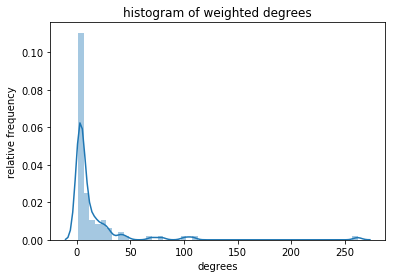

In [71]:
# produce histogram of node degrees
deg_vals = np.array([v for k,v in subgraph.degree(weight='weight')])
ax = sns.distplot(deg_vals)
plt.title('histogram of weighted degrees')
plt.xlabel('degrees')
plt.ylabel('relative frequency')
plt.show()

The graph is highly right skewed.  Most characters have relatively few interactions, and small handful of characters have many interactions. 

This result is not surprising.  We would expect most TV shows to feature many interactions only from main characters that have roles in most episodes.

**Trimmed Graph**

Below is a graph that only includes connected nodes where the edge weight exceeds one.

The graph is dominated by frequent interaction between Tony and his top mafia capos and mafia-related associate, Dick Barone.  Tony also has frequent communications with his sister, Janice.

We also note a significant number of interactions between an FBI official--see the dark blue node--with Big Pussy, one of Tony's mafia capos.

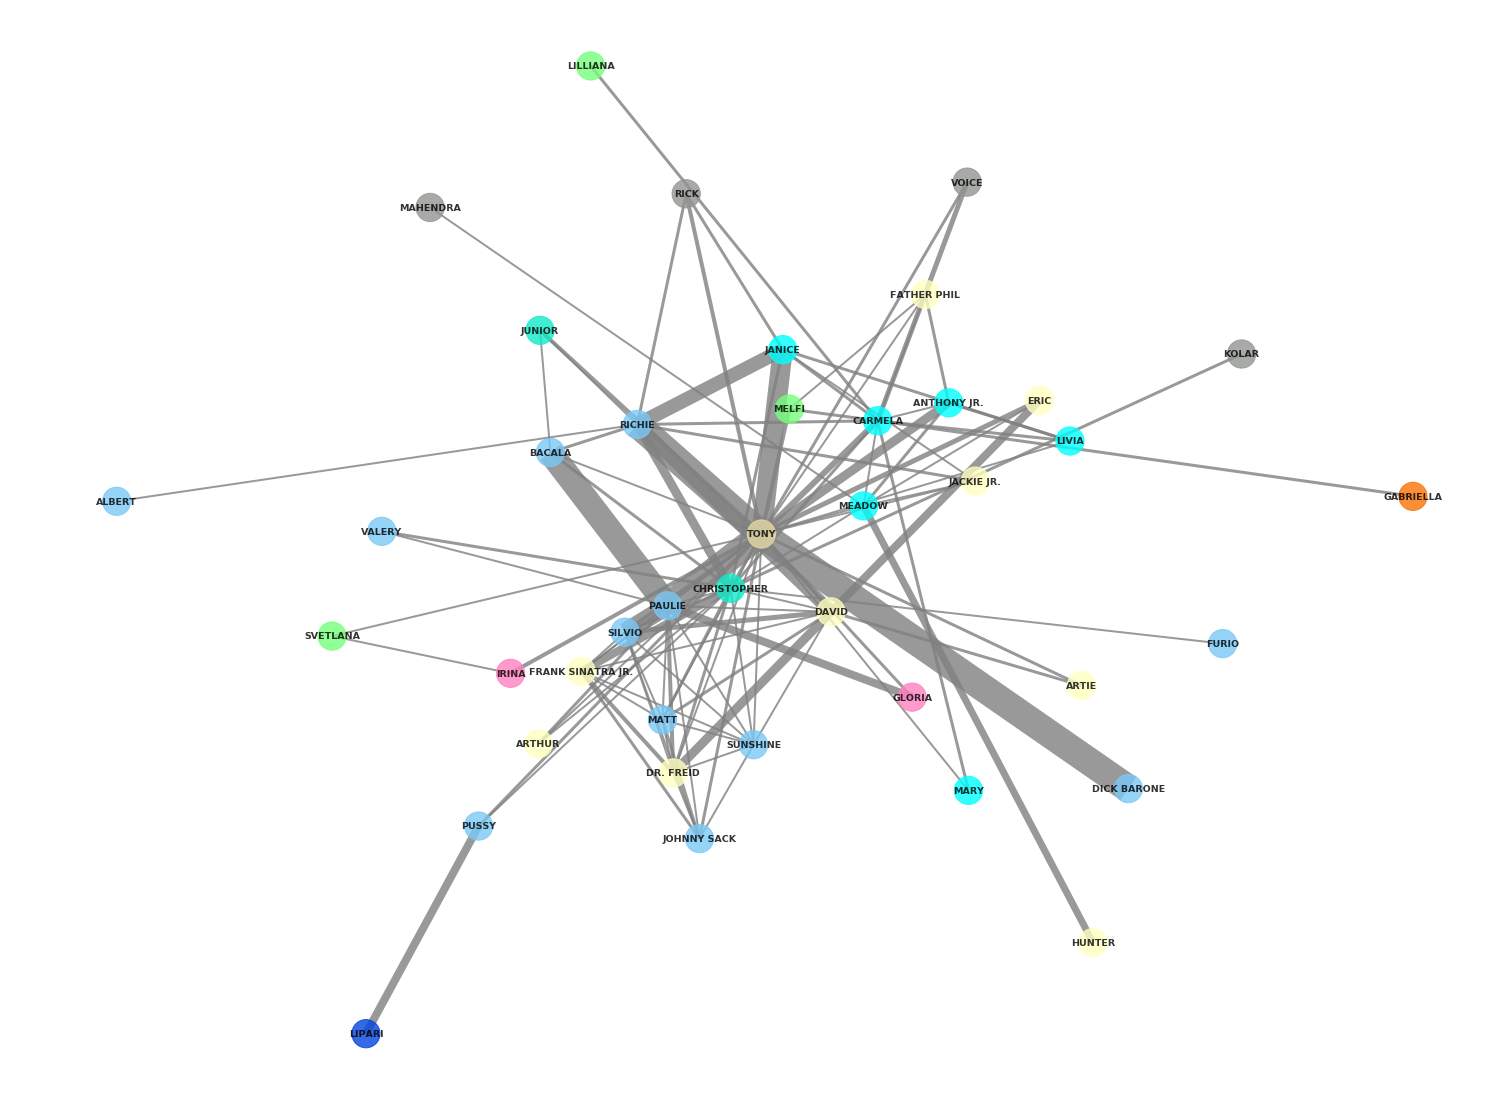

In [77]:
# return graph with weights above specified threshold only
def trim_edges(node_source, edge_source, weight = 1):
    H = nx.Graph()
    H.add_nodes_from(node_source)
    edges = [(k1,k2,v) for (k1,k2,v) in edge_source if v > weight]
    H.add_weighted_edges_from(edges)
    return(H)
   
# trimmed graph
G2sub = trim_edges(characters_all, edge_tuples, weight = 1)

# assign attributes to trimmed graph
char_typ_sub = {}
for n in G2sub.nodes():
    char_typ_sub[n] = char_typ[n]

nx.set_node_attributes(G2sub, char_typ_sub, name='char_typ')
 
# return connected components only
G2sub = list(nx.connected_component_subgraphs(G2sub))[1]

# set colors
node_col_sub = assign_col(G2sub)

# assign weights
edges_sub = G2.edges()
weights_sub = [G2[u][v]['weight'] for u,v in edges_sub]
plt.figure(figsize=(20,15)) 
nx.draw(G2sub, with_labels=True, font_size = 9.5, node_size = 800,\
        font_weight = 'bold', alpha = 0.8, node_color = node_col_sub,  edge_color='gray', 
        pos=nx.spring_layout(G2sub, k=0.40, iterations=20), width = weights_sub)

**Other Centrality Measures** 

Now we'll gauge the importance of characters in the Sopranos universe by reviewing alternative node centrality measures.

Let's start with closeness centrality:

*Closeness Centrality*

In [90]:
# top 15 closeness centrality
close = nx.closeness_centrality(G)
close = sorted(close.items(), key=lambda kv: round(kv[1],2), reverse=True)
[(el[0], round(el[1],2)) for el in close][0:15]


[('TONY', 0.73),
 ('CHRISTOPHER', 0.56),
 ('CARMELA', 0.54),
 ('RICHIE', 0.53),
 ('PAULIE', 0.51),
 ('MEADOW', 0.5),
 ('SILVIO', 0.5),
 ('DAVID', 0.49),
 ('JANICE', 0.48),
 ('PUSSY', 0.48),
 ('MATT', 0.47),
 ('RICK', 0.47),
 ('ANTHONY JR.', 0.47),
 ('SUNSHINE', 0.46),
 ('ERIC', 0.46)]

There are only a couple surprises in this list, as the top characters in terms of closeness centrality are mostly top mafia capos and members in Tony's immediate family.  

Notes on the surprises:
* Tony's friend David was not a major character in the series.  However, the character becomes entrenched with mafia interactions after losing all his money in one of Tony's poker games.
* David's son Eric also is included in the list. He is a classmate of Tony's daughter, Meadow.  His closeness centrality score is elevated by his father's mob interactions.   

*Betweenness Centrality*

In [91]:
# top 15 betweenness centrality
between = nx.betweenness_centrality(G, weight='weight')
between = sorted(between.items(), key=lambda kv: round(kv[1],2), reverse=True)
[(el[0], round(el[1],2)) for el in between][0:15]

[('TONY', 0.41),
 ('RICHIE', 0.16),
 ('PETERS', 0.12),
 ('CARMELA', 0.1),
 ('MEADOW', 0.1),
 ('PAULIE', 0.08),
 ('CHRISTOPHER', 0.08),
 ('JUNIOR', 0.07),
 ('PUSSY', 0.07),
 ('JACKIE JR.', 0.04),
 ('SILVIO', 0.04),
 ('ERIC', 0.03),
 ('ROSALIE', 0.03),
 ('DICK BARONE', 0.03),
 ('FURIO', 0.03)]

Tony is the largest hub connecting disparate groups of characters. There is a steep dropoff in centrality scores for other characters.

Additional Notes:
* While Richie is one of Tony's mafia captains, tension between the two characters is often tense.  Richie is often seen engaging in rogue, criminal activity not formally sanctioned by Tony.  This behavior is likely driving up his betweenness centrality score.
* Peters is former mafia associate turned informant.  He joined the witness protection program and moved far away from New Jersey.  His physical distance from other Sopranos figures likely influence his centraility score. 
* Carmela tries to lead a life that--at first glance--is far removed from the mafia lifestyle.  She interacts with many characters that are not directly related to the mafia, which could be driving up her score.
* Although Christopher is a popular character--judged by other centrality measures--his betweenness centrality score is rather low.  This may be due to the fact that Christopher primarily associates only with other mafia capos, Tony, and his girlfriend Adriana.

*Eigenvector Centrality*

Eigenvector centrality can be used to locate gray cardinals in networks. Gray cardinals are nodes that are not necessarily popular by traditional centrality measures, but have significant interactions with other important nodes.  

Prior to performing this analysis, we expected to expose Tony's mother, Livia, as a gray cardinal.  She has interactions with a relatively small number of characters, but seems to have outsized influence on Tony and Uncle Junior, who is Tony's superior in the mob for much of the series (at least in terms of his title). 

We were also curious about Uncle Junior's eigenvector score.  His title as mob boss suggests tremendous power, but his power is often undermined by Tony and other mafia members.

In [87]:
# top 25 eigenvector centrality scores
eigen = nx.eigenvector_centrality(G, weight = 'weight')
eigen = sorted(eigen.items(), key=lambda kv: round(kv[1],2), reverse=True)
[(el[0], round(el[1],2)) for el in eigen][0:25]

[('TONY', 0.61),
 ('CHRISTOPHER', 0.39),
 ('CARMELA', 0.34),
 ('PAULIE', 0.31),
 ('MEADOW', 0.29),
 ('MELFI', 0.18),
 ('DAVID', 0.12),
 ('ANTHONY JR.', 0.12),
 ('SILVIO', 0.12),
 ('RICHIE', 0.11),
 ('JANICE', 0.11),
 ('BACALA', 0.09),
 ('FATHER PHIL', 0.09),
 ('IRINA', 0.07),
 ('MATT', 0.07),
 ('ARTHUR', 0.06),
 ('SUNSHINE', 0.06),
 ('GLORIA', 0.06),
 ('LIVIA', 0.06),
 ('DR. FREID', 0.06),
 ('JUNIOR', 0.06),
 ('FRANK SINATRA JR.', 0.06),
 ('ERIC', 0.05),
 ('JACKIE JR.', 0.05),
 ('PUSSY', 0.05)]

To our disappointment, Tony's mother has a relatively low eigencentrality measure--her barely cracks the top 20 rankings.  Similarly, Junior's score lands towards the bottom of the top 25 list.

On the other hand, we are intrigued by Dr. Melfi's high eigenvector score.  We can plausibly characterize Melfi as a gray cardinal, as she does not rank highly in other centrality measures.  Her score is almost certainly related to her her frequent therapy sessions with Tony.

Additional observations:  
* Father Phil, a very close friend of Tony's wife, Carmela, ranks high in terms of eigenvector centrality.  He typically does not interact with mafia figures directly, but Carmela does.  This relationship drives up his eigenvector score.  
* We also see that two of Tony's mistresses,  Irina and Gloria, rank fairly high, despite being relatively minor characters in the Sopranos universe.


## Sentiment Analysis

Let's now move and perform some basic sentiment analysis.

We'll review polarity and subjectivity scores for all characters with more than 500 words of dialogue throughout the five episodes examined.

Notes:
* Polarity scores range in value from -1 to 1.  Positive scores are associated with warm sentiment.  Negative scores indicate adverse positions.
* Subjectivity scores range from 0 to 1.  Values close to 0 reflect fact-based statements.  Values closer to one indicate more emotionally charged statements. 
* We used a function, *correct()*, that fixes misspelled and jargon words.  For instance, a work like "jokin' " in the dialogue will be converted to "joking."

In [114]:
# order nodes by degree weights, descending
myorder = sorted([(x,y) for x,y in G.degree(weight='weight')], key=lambda z: z[1], reverse=True)
myorder = [x for (x,y) in myorder]

# sentiment:  polarity, subjectivity, word count
sentiment_dict = dict()
for char in myorder:
    myblob = TextBlob(" ".join(df_all[df_all.character==char].loc[:,'dialogue'])).correct()
    sentiment_dict[char] = [round(myblob.sentiment[0],3), round(myblob.sentiment[1],3), len(myblob.words)]

[(k,v) for k,v in sentiment_dict.items() if v[2] > 500]

[('TONY', [0.041, 0.541, 9547]),
 ('CHRISTOPHER', [-0.13, 0.556, 2110]),
 ('CARMELA', [0.117, 0.478, 2638]),
 ('PAULIE', [-0.092, 0.592, 1776]),
 ('MEADOW', [0.099, 0.555, 1701]),
 ('RICHIE', [-0.094, 0.609, 1187]),
 ('SILVIO', [-0.237, 0.606, 535]),
 ('DAVID', [-0.017, 0.557, 857]),
 ('MELFI', [0.105, 0.496, 1234]),
 ('JANICE', [0.031, 0.536, 994]),
 ('FATHER PHIL', [0.125, 0.608, 891]),
 ('PUSSY', [-0.026, 0.548, 828]),
 ('JUNIOR', [-0.07, 0.549, 1411]),
 ('IRINA', [-0.187, 0.528, 572]),
 ('LIVIA', [0.036, 0.632, 576])]

**Polarity**

Notes on polarity:
* Tony uses a lot of colorful, and sometimes violent language.  We were surprised to that is overall tone is slightly positive.
* The highest polarity score for characters with significant speaking roles is Carmela, Tony's wife.
* The lowest score belongs to Silvio, Tony's consigliere.
* Tony's mistress, IRINA, also displays significant negative sentiment.

Let's review lines of dialogue from Carmela and Silvio.  Based on our subjective review, the sentiment model appears to be doing a good job of summarizing aggregate sentiment.

In [101]:
df_all[df_all.character == 'SILVIO'].loc[557:,['character','dialogue']]

,character,dialogue
557,SILVIO,Shut the fuck up and deal.
563,SILVIO,What’s the bet?
569,SILVIO,What the fuck can you possibly have?
573,SILVIO,"You’re not lying, you miserable cunt."
579,SILVIO,Don’t rush me. You’ve been rushing me all fuck...
587,SILVIO,"Do you fuckin’ mind? Jesus, you don’t shut the..."
593,SILVIO,I’m losin’ my fuckin’ balls here and this fuck...
597,SILVIO,Why? Why now? Leave it there.
601,SILVIO,I don’t fuckin’ believe this idiot.
602,SILVIO,Where do you get these fuckin’… sweeping chees...


In [107]:
df_all[df_all.character == 'CARMELA'].loc[:,['character','dialogue']]

,character,dialogue
51,CARMELA,"Have something more than just cranapple juice,..."
55,CARMELA,"Girls, you want some of last night’s sfogliate..."
59,CARMELA,"Oh, have a bite."
89,CARMELA,"Miss Meadow, we made a deal — you keep your sc..."
95,CARMELA,You’re going to be home tonight for Tony
96,CARMELA,"Jr.’s party, right?"
97,CARMELA,Birdman. Hello?
101,CARMELA,I wasn’t talking about work.
350,CARMELA,No way. She’s jerking your chain.
362,CARMELA,Your mother’s tougher than you think.


**Subjectivity**

Many of the Sopranos characters have subjectivity scores close to 0.50, which indicates dialogue that is evenly balanced between facts and emotional content.

Tony's mother, Livia, has the highest subjectivity score, at 0.632.  Carmela's friend Father Phil also scores relatively high in terms of emotional content.

On the other hand, Tony's therapist, Dr. Melfi, has a subjectivity score slightly below 0.5.  Tony's wife also as a low subjectivity score.

Let's now look at some of the dialogue involving Livia and Dr. Melfi.


In [108]:
# LIVIA dialogue
df_all[df_all.character == 'LIVIA'].loc[:,['character','dialogue']]

,character,dialogue
274,LIVIA,Did you lock the door behind you?
278,LIVIA,Somebody phone me last night. After dark.
282,LIVIA,You think I’d answer the phone? It was dark out.
286,LIVIA,Listen to him. He knows everything. You want s...
292,LIVIA,That one. Think he ever comes to see his siste...
296,LIVIA,I still see his mother. She tells me he calls ...
300,LIVIA,What’s that?
304,LIVIA,For who? For me? I don’t want it.
311,LIVIA,He was a saint.
315,LIVIA,Don’t you tell me how to live. You shut up.


In [115]:
# Melfi dialogue
df_all[df_all.character == 'MELFI'].loc[:,['character','dialogue']]

,character,dialogue
2,MELFI,Mr. Soprano?
5,MELFI,Have a seat.
7,MELFI,"My understanding from your family physician, D..."
11,MELFI,You don’t agree you had a panic attack?
13,MELFI,How are you feeling now?
17,MELFI,What line of work are you in?
21,MELFI,Any thoughts at all on why you blacked out?
25,MELFI,Stress? About what?
35,MELFI,"Many Americans, I think, feel this."
39,MELFI,Did you have this feeling of loss more acutely...


## Polarity Over Time


Now let's calculate polarity measure for our characters on a per episode basis.

In [161]:
# look at characters with significant dialogue
names = [k for k,v in sentiment_dict.items() if v[2] > 500]

# function to calculate sentiment
def sentiment(df, chars):
    sentiment_dict = dict()
    for char in chars:
        myblob = TextBlob(" ".join(df[df.character==char].loc[:,'dialogue'])).correct()
        sentiment_dict[char] = [round(myblob.sentiment[0],3), round(myblob.sentiment[1],3), len(myblob.words)]
    return(sentiment_dict)

# sentiment by episode
sentiment1 = sentiment(df1, names)
sentiment2 = sentiment(df2, names)
sentiment3 = sentiment(df3, names)
sentiment4 = sentiment(df4, names)
sentiment5 = sentiment(df5, names)


Below is a dictionary of polarity measures over time for each major character:

In [216]:
# create polarity value by episode
pol_dict = {}
for nm in names:
    pol_dict[nm] = [sentiment1.get(nm)[0]]
    pol_dict[nm].append(sentiment2.get(nm)[0])
    pol_dict[nm].append(sentiment3.get(nm)[0])
    pol_dict[nm].append(sentiment4.get(nm)[0])
    pol_dict[nm].append(sentiment5.get(nm)[0])

# sentiment is listed is 0 in episodes where characters are missing
# convert to nan
pol_dict['PAULIE'][1] = np.nan
pol_dict['RICHIE'][0] = np.nan
pol_dict['RICHIE'][1] = np.nan
pol_dict['SILVIO'][1] = np.nan
pol_dict['DAVID'][0] = np.nan
pol_dict['DAVID'][1] = np.nan
pol_dict['DAVID'][3] = np.nan
pol_dict['DAVID'][4] = np.nan
pol_dict['JANICE'][0] = np.nan
pol_dict['JANICE'][1] = np.nan
pol_dict['JANICE'][2] = np.nan
pol_dict['JANICE'][4] = np.nan
pol_dict['FATHER PHIL'][2] = np.nan
pol_dict['FATHER PHIL'][3] = np.nan
pol_dict['FATHER PHIL'][4] = np.nan
pol_dict['JUNIOR'][1] = np.nan
pol_dict['IRINA'][2] = np.nan
pol_dict['LIVIA'][1] = np.nan
pol_dict['LIVIA'][2] = np.nan
pol_dict['LIVIA'][4] = np.nan
pol_dict['PUSSY'][1] = np.nan
pol_dict['PUSSY'][2] = np.nan
pol_dict['PUSSY'][4] = np.nan

# LOOK AT POLARITY OVER TIME
pol_dict

{'TONY': [0.095, 0.044, -0.061, 0.03, 0.112],
 'CHRISTOPHER': [-0.043, 0.004, -0.204, -0.178, -0.159],
 'CARMELA': [0.289, 0.102, -0.038, 0.008, -0.016],
 'PAULIE': [-0.571, nan, -0.082, 0.0, -0.08],
 'MEADOW': [-0.115, 0.174, 0.161, 0.0, -0.005],
 'RICHIE': [nan, nan, -0.05, -0.127, 0.0],
 'SILVIO': [-0.24, nan, -0.33, 0.064, 0.0],
 'DAVID': [nan, nan, -0.017, nan, nan],
 'MELFI': [0.099, 0.048, -0.06, 0.225, 0.269],
 'JANICE': [nan, nan, nan, 0.031, nan],
 'FATHER PHIL': [0.006, 0.135, nan, nan, nan],
 'PUSSY': [-0.13, nan, nan, 0.05, nan],
 'JUNIOR': [0.017, nan, -0.133, -0.019, -0.167],
 'IRINA': [0.2, 0.01, nan, -0.263, -0.105],
 'LIVIA': [-0.09, nan, nan, 0.156, nan]}

Let's now look at a plot of polarity for the five major characters that have speaking lines in all five episodes:

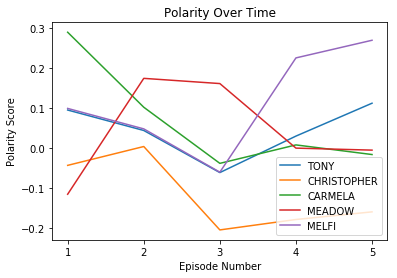

In [225]:
# plot character sentiment over time
plt.plot([1,2,3,4,5],pol_dict['TONY'], label = 'TONY')
plt.plot([1,2,3,4,5],pol_dict['CHRISTOPHER'], label='CHRISTOPHER')
plt.plot([1,2,3,4,5],pol_dict['CARMELA'], label = 'CARMELA')
plt.plot([1,2,3,4,5],pol_dict['MEADOW'], label = 'MEADOW')
plt.plot([1,2,3,4,5],pol_dict['MELFI'], label = 'MELFI')
plt.xticks(np.arange(1, 6, 1.0))
plt.xlabel('Episode Number')
plt.ylabel('Polarity Score')
plt.title('Polarity Over Time')
plt.legend(loc='bottom')
plt.show()

Finally, let's look at standard deviation of polarity for all major characters:

In [206]:
# look at standard deviations 
[(k,round(np.nanstd(v),3)) for k,v in pol_dict.items()]

[('TONY', 0.061),
 ('CHRISTOPHER', 0.081),
 ('CARMELA', 0.12),
 ('PAULIE', 0.226),
 ('MEADOW', 0.11),
 ('RICHIE', 0.052),
 ('SILVIO', 0.163),
 ('DAVID', 0.0),
 ('MELFI', 0.119),
 ('JANICE', 0.0),
 ('FATHER PHIL', 0.064),
 ('PUSSY', 0.06),
 ('JUNIOR', 0.077),
 ('IRINA', 0.169),
 ('LIVIA', 0.123)]

Notes on time-based polarity:  
* Christopher uses consistently negative language.
* Carmela's sentiment exhibits a significant downward trend over time.  This likely corresponds relationship troubles with Tony.
* Dr. Melfi's sentiment almost perfectly matches Tony's for the first three episodes.  This may be due to Melfi echoing Tony's mood during therapy sessions.
* Tony's sentiment exhibits a downward trend through the first three episodes before rebounding.  The upward trajectory in later episodes may correspond to a new love interest.

## Tony's Relationship with his Mother, Livia

If you have seen a few episodes of *The Sopranos*, you probably know that the relationship between Tony and his mother is often very strained.

Before exploring this relationship, let's determine the episodes and scenes in which both Tony and Livia appear:

In [281]:
# determine scenes livia is in
livia_scenes = df_all[(df_all.character == 'LIVIA')]
livia_scenes = livia_scenes.groupby(['episode',"scene"]).size().reset_index().rename(columns={0:'count'})

# determine scenes tony is in
tony_scenes = df_all[(df_all.character == 'TONY')]
tony_scenes = tony_scenes.groupby(['episode',"scene"]).size().reset_index().rename(columns={0:'count'})

# include scenes with both tony and livia
tony_livia_scenes = pd.merge(tony_scenes, livia_scenes, on = ['episode','scene'])
tony_livia_dialogue = pd.merge(df_all, tony_livia_scenes, on = ['episode','scene'])
tony_livia_dialogue = tony_livia_dialogue[(tony_livia_dialogue.character == 'TONY') | (tony_livia_dialogue.character == 'LIVIA')]

# show example dialogue
tony_livia_dialogue.head(10)


,episode,line_type,scene,character,dialogue,count_x,count_y
0,1,dialogue,29,TONY,"Jeez, Ma, get some air in here.",19,15
1,1,dialogue,29,LIVIA,Did you lock the door behind you?,19,15
2,1,dialogue,29,TONY,Yes.,19,15
3,1,dialogue,29,LIVIA,Somebody phone me last night. After dark.,19,15
4,1,dialogue,29,TONY,Who?,19,15
5,1,dialogue,29,LIVIA,You think I’d answer the phone? It was dark out.,19,15
6,1,dialogue,29,TONY,"Ma, that I will never get. The phone is an aud...",19,15
7,1,dialogue,29,LIVIA,Listen to him. He knows everything. You want s...,19,15
8,1,dialogue,29,TONY,I just ate.,19,15
9,1,dialogue,29,TONY,Know who I just saw? Uncle Junior.,19,15


Tony and Livia appear in two episodes together.  Let's see how the relationship evolves between the two episodes.  The first episode is from the series premiere.  The other episode is from the end of season two.

In [278]:
# analyze polarity in episode 1: pilot episode season one
analyser = SentimentIntensityAnalyzer()

tony_text = " ".join(tony_livia_dialogue[(tony_livia_dialogue.character == 'TONY') & \
                                         (tony_livia_dialogue.episode == 1)].loc[:,'dialogue'])
livia_text = " ".join(tony_livia_dialogue[(tony_livia_dialogue.character == 'LIVIA') & \
                                          (tony_livia_dialogue.episode == 1)].loc[:,'dialogue'])

print("Tony talking to Livia: ", analyser.polarity_scores(tony_text))
print("Livia talking to Tony: ", analyser.polarity_scores(livia_text))

Tony talking to Livia:  {'neg': 0.055, 'neu': 0.797, 'pos': 0.148, 'compound': 0.9802}
Livia talking to Tony:  {'neg': 0.017, 'neu': 0.885, 'pos': 0.098, 'compound': 0.9435}


In [277]:
# analyze polarity in 4th episode in our book, from season 2, episode 12
analyser = SentimentIntensityAnalyzer()

tony_text = " ".join(tony_livia_dialogue[(tony_livia_dialogue.character == 'TONY') & \
                                         (tony_livia_dialogue.episode == 4)].loc[:,'dialogue'])
livia_text = " ".join(tony_livia_dialogue[(tony_livia_dialogue.character == 'LIVIA') & \
                                          (tony_livia_dialogue.episode == 4)].loc[:,'dialogue'])

print("Tony talking to Livia: ", analyser.polarity_scores(tony_text))
print("Livia talking to Tony: ", analyser.polarity_scores(livia_text))

Tony talking to Livia:  {'neg': 0.155, 'neu': 0.819, 'pos': 0.026, 'compound': -0.8668}
Livia talking to Tony:  {'neg': 0.07, 'neu': 0.782, 'pos': 0.148, 'compound': 0.9404}


Clearly, the relationship has become more contentious over time. In the first episode, both characters use more positive language than negative language when speaking to each other. 

By the second season, however, Tony is using negative language about 50% more often than positive language. 

## Video Commentary

* Part 1: http://youtu.be/woxxAGhjTsc?hd=1  
* Part 2: http://youtu.be/mZTXeDgUld0?hd=1

## References

- Chase, David. *[The Sopranos: Selected Scripts from Three Seasons](https://www.amazon.com/dp/B002PXFY4M/ref=dp-kindle-redirect?_encoding=UTF8&btkr=1)*. Warner Books, 2002. 
- Tsvetovat, Maksim, and Alexander Kouznetsov. Social Network Analysis for Startups. OReilly, 2012
- Overview of the series: https://en.wikipedia.org/wiki/The_Sopranos
- List of episodes: https://en.wikipedia.org/wiki/List_of_The_Sopranos_episodes
- Season one, episode one recap: https://en.wikipedia.org/wiki/The_Sopranos_(The_Sopranos_episode)
- Season one, episode five recap: https://en.wikipedia.org/wiki/College_(The_Sopranos)
- Season two, episode six recap: https://en.wikipedia.org/wiki/The_Happy_Wanderer_(The_Sopranos)  
- Season two, episode twelve recap: https://en.wikipedia.org/wiki/The_Knight_in_White_Satin_Armor
- Season three, episode eleven recap: https://en.wikipedia.org/wiki/Pine_Barrens_(The_Sopranos)
- Sentiment analysis: https://www.geeksforgeeks.org/twitter-sentiment-analysis-using-python/
- More sentiment analysis: https://medium.com/analytics-vidhya/simplifying-social-media-sentiment-analysis-using-vader-in-python-f9e6ec6fc52f